In [2]:
# importing modules.
import torch
import torch.nn.functional as F
import numpy as np
from torch import nn, optim
from torchvision import transforms, datasets

In [3]:
# defining transforms for images.
transform = transforms.Compose([transforms.ToTensor()])

In [4]:
# Loading data from dataset

# Training Data
train_data = datasets.MNIST('data', train=True, download=True, transform=transform)

#Testing Data
test_data = datasets.MNIST('data', train=False, download=True, transform=transform)

In [5]:
# Spliting train data index into train and validation
num_train = len(train_data)
idxs = list(range(num_train))
np.random.shuffle(idxs)

# using 20% of train data for validation.
split = int(np.floor(0.2 * num_train))
train_idx = idxs[split:]
valid_idx = idxs[:split]

In [6]:
# samplers to obtain indices for batches.
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

In [7]:
# defining loader to load data in batches.
# defining batch size
batch_size = 20

# Training loader
train_loader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Validation loader
valid_loader = torch.utils.data.DataLoader(train_data, sampler=valid_sampler, batch_size=batch_size)

# testing loader
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [8]:
# Now let's see the data we loaded visually.
# import matplot library
%matplotlib inline
import matplotlib.pyplot as plt

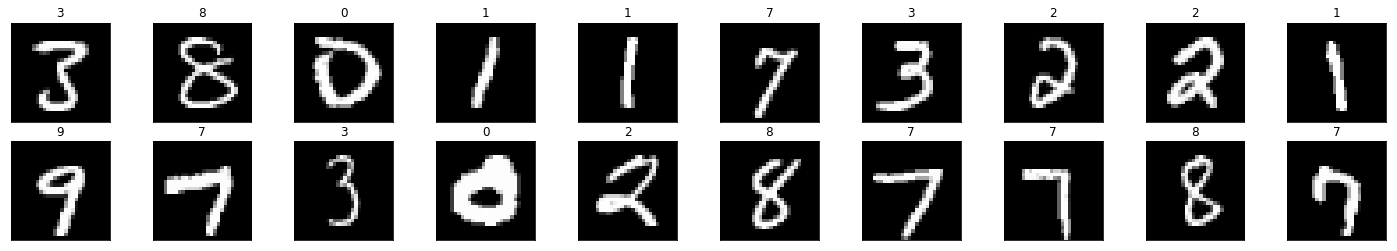

In [9]:
# taking one batch from train_loader 
images, labels = iter(train_loader).next()

# converting images from tensor to numpy array just for visulization. 
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for i in range(20):
    ax = fig.add_subplot(2, 20/2, i + 1, xticks=[], yticks=[])
    ax.set_title(labels[i].item())
    ax.imshow(np.squeeze(images[i]), cmap='gray')

## Defining network architecture.
Each image is **28 X 28** means if we flatten the image it will be 784 px. Thus input layer will have **784 units**.The number of digits 0-9, **10** output for output layer.

* Input Layer

    * 784 input units, 128 output units.
    

* hidden Layer 1

    * 128 input units, 64 output units.
    
    
* hidden Layer 2

    * 64 input units, 32 output units.
    

* output Layer
    
    * 32 input units, 10 output units.
    
Activation function : _Relu_

Dropout with p=0.2
    

In [10]:
# Defining network architecture.
class Network(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        # Input layer: 784 => 128.
        self.fc1 = nn.Linear(784, 128)
        
        # Hidden layer 1: 128 => 64.
        self.fc2 = nn.Linear(128, 64)
        
        # Hidden Layer 2: 64 => 32.
        self.fc3 = nn.Linear(64, 32)
        
        # Output layer 3: 32 => 10.
        self.fc4 = nn.Linear(32, 10)
        
        # Defining dropout with p = 0.2
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, X):
        
        # Flatten inputs.
        X = X.view(-1, 784)
        
        # Input Layer.
        X = self.dropout(F.relu(self.fc1(X)))
        
        # Hidden Layer 1
        X = self.dropout(F.relu(self.fc2(X)))
        
        # Hidden Layer 2
        X = self.dropout(F.relu(self.fc3(X)))
        
        # Output Layer with log_sofmax function.
        X = F.log_softmax(self.fc4(X), dim=1)
        
        return X
        
        

In [11]:
# Instance of Network
model = Network()
model

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)

In [12]:
# Defining optimzer and loss function.
# Loss function : NLLLoss
criterion = nn.CrossEntropyLoss()

# # optimzer Adam
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [13]:
# training model

# Epochs for training.
epochs = 50

# defining min_valid loss to np.inf
valid_min = np.inf

for i in range(epochs):
    
    # set model for training.
    model.train()
    
    # defining train loss and validation loss to 0.0 later we calculate using loss function.
    train_loss = 0.0
    valid_loss = 0.0
    
    for images, labels in train_loader:
        
        # cleaning gradient for all optimized variables.
        optimizer.zero_grad()
        
        # forwardpass passing images to model
        output = model(images)
        
        # Calculating loss to perform backward pass
        loss = criterion(output, labels)
        
        # backward pass compute loss with resp to parameters.
        loss.backward()
        
        # optimizer single step.
        optimizer.step()
        
        # updating total loss
        train_loss += loss.item() * images.size(0)
        
    # set model for evalutaion.
    model.eval()
    
    # validating model.
    for images, labels in valid_loader:
        
         # forwardpass passing images to model
        output = model(images)
        
        # Calculating loss to perform backward pass
        loss = criterion(output, labels)
        
        # Updating total validation loss.
        valid_loss += loss.item() * images.size(0)
        
    train_loss = train_loss / len(train_loader.dataset)
    valid_loss = valid_loss / len(valid_loader.dataset)
    
    print("Training loss:", train_loss, "\tValidation loss:", valid_loss, "\tEpoch:", str(i+1))
    
    if valid_loss <= valid_min:
        print("Saving model.")
        torch.save(model.state_dict(), 'model_handwritten.pth')
        valid_min = valid_loss

Training loss: 1.369497035264969 	Validation loss: 0.14129491144418715 	Epoch: 1
Saving model.
Training loss: 0.5417618000159661 	Validation loss: 0.07794534774497151 	Epoch: 2
Saving model.
Training loss: 0.36400498628616335 	Validation loss: 0.05742697741712133 	Epoch: 3
Saving model.
Training loss: 0.28342704605311153 	Validation loss: 0.046619206969315805 	Epoch: 4
Saving model.
Training loss: 0.2392296978632609 	Validation loss: 0.03977552443742752 	Epoch: 5
Saving model.
Training loss: 0.2073348666615784 	Validation loss: 0.03445289965253323 	Epoch: 6
Saving model.
Training loss: 0.18494329973046358 	Validation loss: 0.031536349616634346 	Epoch: 7
Saving model.
Training loss: 0.1662462861094003 	Validation loss: 0.029349636874782543 	Epoch: 8
Saving model.
Training loss: 0.1565386937484145 	Validation loss: 0.02756685497596239 	Epoch: 9
Saving model.
Training loss: 0.14311629359874253 	Validation loss: 0.02730406421861456 	Epoch: 10
Saving model.
Training loss: 0.1313079444590645

In [14]:
# Testing Model.
# Initilizing list to moniter test and accuracy.
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# prepate mode for evalution.
model.eval()

for images, labels in test_loader:
    
    # forwardpass passing images to model
    output = model(images)
    
    # calculate the loss
    loss = criterion(output, labels)
    
    # update test loss 
    test_loss += loss.item() * images.size(0)
    
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    
    # compare predictions to true label
    correct = np.squeeze(pred.eq(labels.data.view_as(pred)))
    
     # calculate test accuracy for each object class
    for i in range(batch_size):
        
        label = labels.data[i]
        
        class_correct[label] += correct[i].item()
        
        class_total[label] += 1
        
# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.092023

Test Accuracy of     0: 98% (969/980)
Test Accuracy of     1: 98% (1122/1135)
Test Accuracy of     2: 97% (1011/1032)
Test Accuracy of     3: 98% (993/1010)
Test Accuracy of     4: 97% (956/982)
Test Accuracy of     5: 97% (869/892)
Test Accuracy of     6: 98% (939/958)
Test Accuracy of     7: 97% (1002/1028)
Test Accuracy of     8: 97% (947/974)
Test Accuracy of     9: 96% (975/1009)

Test Accuracy (Overall): 97% (9783/10000)


In [15]:
# Visualize data with test result.
# obtain one batch of test images
dataiter = iter(test_loader)

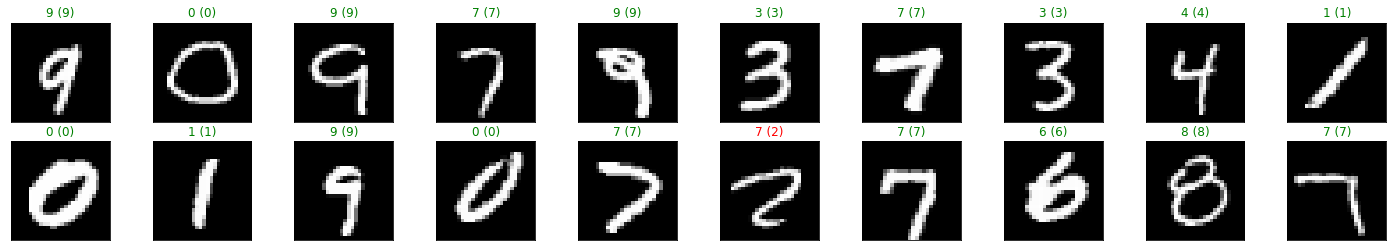

In [17]:

images, labels = dataiter.next()

# get sample outputs
output = model(images)

# convert output probabilities to predicted class
_, preds = torch.max(output, 1)

# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))